In [20]:
%matplotlib inline
import sys
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import flopy
from flopy.utils.reference import SpatialReference

In [21]:
outpath = 'data'
#if os.path.isdir(outpath):
#    shutil.rmtree(outpath)
#os.mkdir(outpath)

# Define grid and spatial parameters
```SpatialReference``` is a stand-alone option that describes the location of the model grid in a real-world coordinate reference system. It can be created with some basic information about the model's location

In [22]:
l = w = 106216.704 
xll, yll = 2247000.00, 1330950.00 # origin of the model [m] (lower left corner)
dxdy = 1609.344 # grid spacing (in model units) 
nrow = ncol = int(np.round(l/dxdy))
rot = -2 # rotation (positive ccw)

# Specify coordinate system with custom Proj4 string for IDTM83
model_proj4 = '+proj=tmerc +lat_0=42 +lon_0=-114 +k=0.9996 +x_0=2500000 +y_0=1200000 +ellps=GRS80 +units=m +no_defs'

# row and column spacings
# (note that delc is column spacings along a row; delr the row spacings along a column)
delc = np.ones(nrow, dtype=float) * dxdy
delr = np.ones(ncol, dtype=float) * dxdy

sr = SpatialReference(delr=delr, delc=delc, xll=xll, yll=yll, rotation=rot, proj4_str = model_proj4)

In [23]:
sr

xul:2250706.91; yul:1437102; rotation:-2; proj4_str:+proj=tmerc +lat_0=42 +lon_0=-114 +k=0.9996 +x_0=2500000 +y_0=1200000 +ellps=GRS80 +units=m +no_defs; units:meters; lenuni:2; length_multiplier:1.0

## Grid coordinate information
### cell centroids

In [24]:
sr.xcentergrid[0],sr.ycentergrid[0]

(array([ 2251483.00867875,  2253091.37230986,  2254699.73594098,
         2256308.0995721 ,  2257916.46320322,  2259524.82683434,
         2261133.19046546,  2262741.55409657,  2264349.91772769,
         2265958.28135881,  2267566.64498993,  2269175.00862105,
         2270783.37225217,  2272391.73588328,  2274000.0995144 ,
         2275608.46314552,  2277216.82677664,  2278825.19040776,
         2280433.55403887,  2282041.91766999,  2283650.28130111,
         2285258.64493223,  2286867.00856335,  2288475.37219447,
         2290083.73582558,  2291692.0994567 ,  2293300.46308782,
         2294908.82671894,  2296517.19035006,  2298125.55398118,
         2299733.91761229,  2301342.28124341,  2302950.64487453,
         2304559.00850565,  2306167.37213677,  2307775.73576788,
         2309384.099399  ,  2310992.46303012,  2312600.82666124,
         2314209.19029236,  2315817.55392348,  2317425.91755459,
         2319034.28118571,  2320642.64481683,  2322251.00844795,
         2323859.37207907

### Cell vertices

In [25]:
sr.vertices

[[[2250706.9095109985, 1437101.9996538025],
  [2250650.744215377, 1435493.6360226844],
  [2252259.107846495, 1435437.4707270632],
  [2252315.2731421166, 1437045.8343581813],
  [2250706.9095109985, 1437101.9996538025]],
 [[2252315.2731421166, 1437045.8343581813],
  [2252259.107846495, 1435437.4707270632],
  [2253867.471477614, 1435381.305431442],
  [2253923.636773235, 1436989.6690625602],
  [2252315.2731421166, 1437045.8343581813]],
 [[2253923.636773235, 1436989.6690625602],
  [2253867.471477614, 1435381.305431442],
  [2255475.835108732, 1435325.1401358207],
  [2255532.0004043533, 1436933.5037669388],
  [2253923.636773235, 1436989.6690625602]],
 [[2255532.0004043533, 1436933.5037669388],
  [2255475.835108732, 1435325.1401358207],
  [2257084.19873985, 1435268.9748401996],
  [2257140.3640354713, 1436877.3384713177],
  [2255532.0004043533, 1436933.5037669388]],
 [[2257140.3640354713, 1436877.3384713177],
  [2257084.19873985, 1435268.9748401996],
  [2258692.5623709685, 1435212.8095445784],


### Transformations
#### model coordinates to real-world coordinates

In [26]:
sr.transform(50,50)

(2247051.7145161862, 1330998.2245665158)

#### Real-world coordinates to model coordinates
Looking at the confluence of Dry Creek w/ the Boise (2308780.21693, 1390551.70342)

In [27]:
sr.transform(2308780.21693,1390551.70342)

(4602903.3249911629, 2640079.3493261784)

#### Model row,column for real-world coordinates

In [28]:
sr.get_rc(2308780.21693, 1390551.70342)

(28, 36)

#### Write shapefile and PEST grid spec file

In [10]:
sr.write_shapefile(os.path.join(outpath,'gis', 'grid.shp'))
sr.write_gridSpec(os.path.join(outpath, 'gis','grid.spc'))

wrote data\gis\grid.shp


# Add ``` Spatial Reference ``` to model

In [29]:
ml = flopy.modflow.Modflow(modelname = 'TV', exe_name = 'mf2005', model_ws = outpath )
#flopy.modflow.ModflowDis( ml )

The model starts out with Flopy defaults. I'll try to add the spatial reference object ```sr``` to the model object ```ml```

In [30]:
ml

MODFLOW 0 layer(s), 0 row(s), 0 column(s), 0 stress period(s)

In [31]:
ml.sr = sr

Exception: cannot set SpatialReference -ModflowDis not found

The model has no defined packages and thus no where to put spatial information. Initialize a DIS package to make place 
where we can store spatial and grid information. It seems that the DIS package does not recognize paramters in the SpatialReference module, 
so I'll define them here explicitly.

In [32]:
# Model domain and grid definition
ztop = 1200. # Dry Creek enters model boundary @ around 1185 masl
zbot = 652. - 50. #Snake leaves around 652 masl, say aquifer is 50m thick
nlay = 2
nrow = sr.nrow
ncol = sr.ncol
delr = dxdy
delc = dxdy
delv = (ztop - zbot) / nlay
botm = np.linspace(ztop, zbot, nlay + 1)

# Time discretization 
dis = flopy.modflow.ModflowDis(ml, nlay ,nrow, ncol , delr=delr, delc=delc ,top=1200, botm=602)
ml


MODFLOW 2 layer(s), 66 row(s), 66 column(s), 1 stress period(s)

In [33]:
ml.sr = sr
ml.sr

xul:2250706.91; yul:1437102; rotation:-2; proj4_str:+proj=tmerc +lat_0=42 +lon_0=-114 +k=0.9996 +x_0=2500000 +y_0=1200000 +ellps=GRS80 +units=m +no_defs; units:meters; lenuni:2; length_multiplier:1.0

In [ ]:
dis.write_file(os.path.join(outpath,'test.dis'))

## Raterizing Features

In [34]:
import fiona 
from rasterio.features import rasterize
from rasterio import Affine
import rasterio

### Read in a shapefile of streams

In [35]:
shpname = os.path.join(outpath,'gis','TV_bound_2010.shp')
with fiona.open(shpname) as src:
    records = [r for r in src]

geoms = [r['geometry'] for r in records]
attr = [r['properties'] for r in records]

geoms = [(g, attr[i]['cat']) for i, g in enumerate(geoms)]


dx = ml.dis.delr.array[0]
dy = ml.dis.delc.array[0]
trans = Affine(dx, ml.sr.rotation, ml.sr.xul,
               ml.sr.rotation, -dy, ml.sr.yul)
trans

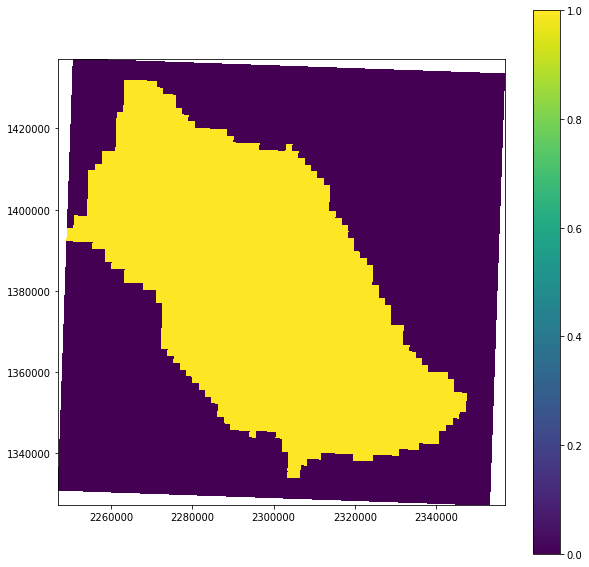

In [39]:
rbound = rasterize(geoms, out_shape=(ml.nrow, ml.ncol), transform=trans)
fig, ax = plt.subplots()
qm = ml.sr.plot_array(rbound, ax=ax)
ax.set_aspect(1)
fig.set_size_inches((10,10))
plt.colorbar(qm)

In [ ]:
shpname = os.path.join(outpath,'gis','streams_simple.shp')
with fiona.open(shpname) as src:
    records = [r for r in src]
geoms = [r['geometry'] for r in records]
attr = [r['properties'] for r in records]
geoms = [(g, attr[i]['cat']) for i, g in enumerate(geoms) if g]

In [ ]:
trans

In [ ]:
rstream = rasterize(geoms, out_shape=(ml.nrow, ml.ncol), transform=trans)
rstream[rstream>0] = 2
fig, ax = plt.subplots()
qm = ml.sr.plot_array(rstream, ax=ax)
ax.set_aspect(1)
fig.set_size_inches((10,10))
plt.colorbar(qm)


# Rasterize streams shapefile in native projection

In [ ]:
with fiona.open( os.path.join(root,'gis','streams_simple.shp')) as streams:
    records = [r for r in streams]
geoms = [r['geometry'] for r in records ]
attr = [r['properties'] for r in records ]
geoms = [(g, attr[i]['cat']) for i, g in enumerate(geoms) if g]

rstream = rasterize(geoms, out_shape=(nrow, ncol))

In [ ]:
with fiona.open(shpname) as src:
    proj=src.crs
    
new_dataset = rasterio.open(os.path.join(outpath,'testrast.tif'), 'w', driver='GTiff',
                            height=rstream.shape[0], width=rstream.shape[1],
                            count=1, dtype=np.uint16,
                            crs=proj)



In [ ]:
new_dataset.write(rstream,1)

new_dataset.close()

In [ ]:
rstream[rbound == 0] = 0
rbound[rstream > 0] = 0
fig, ax = plt.subplots()
qm = ml.sr.plot_array(rbound + rstream, ax=ax)
ax.set_aspect(1)
fig.set_size_inches((10,10))
plt.colorbar(qm)


In [ ]:
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
strt = 10. * np.ones((nlay, nrow, ncol), dtype=np.float32)

In [ ]:
ibound=rbound

In [ ]:
bas = flopy.modflow.ModflowBas(ml, ibound=ibound)

In [ ]:
ml.write_input()

## Input DEM as top of aquifer

In [ ]:
import rasterio
from rasterio.warp import reproject, Resampling
with rasterio.open(os.path.join(outpath,'gis','dem.tif')) as r:
    dem = r.read(1)
    r.read_mask
    newdem = np.empty(shape=rbound.shape)
    aff = r.affine
    newaff = Affine(aff.a / (30./1000), aff.b, aff.c, aff.d, aff.e / (30./1000), aff.f)
    reproject(dem, newdem,
              src_transform = aff,
              dst_transform = newaff,
              src_crs = r.crs,
              dst_crs = r.crs,
              resampling = Resampling.bilinear)
    newdem[np.isnan(newdem)] = -999

In [ ]:
fig, ax = plt.subplots()
qm = ml.sr.plot_array(newdem, ax=ax)
ax.set_aspect(1)
fig.set_size_inches((10,10))
plt.colorbar(qm)

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.imshow(dem)
ax.set_aspect(1)


#### Upsampling with decimated read

In [ ]:
with rasterio.open(os.path.join(outpath,'gis','dem.tif')) as r:
    
    newdem = np.empty(shape=(1,105,105))
    dem = r.read(out=newdem)    
    dem[np.isnan(newdem)] = -999
    dem = dem[0]
    
fig, ax = plt.subplots()
qm = ml.sr.plot_array(dem, ax=ax)

ax.set_aspect(1)
fig.set_size_inches((10,10))
plt.colorbar(qm)

In [ ]:
with rasterio.open(os.path.join(outpath,'gis','dem.tif')) as r:
    dem = r.read(out=newdem)    
    dem[np.isnan(newdem)] = -999
    
dem   

In [ ]:
bas.ibound.plot()

### Load in the grid shapefile created and mask the DEM

In [ ]:
from rasterio.tools.mask import mask

with fiona.open(os.path.join(outpath,'gis','grid.shp'), "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]

with rasterio.open(os.path.join(outpath,'gis','dem.tif')) as src:
    out_image, out_transform = mask(src, geoms, crop=True)
    out_meta = src.meta.copy()

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

#with rasterio.open("/tmp/masked.tif", "w", **out_meta) as dest:
#    dest.write(out_image)

In [ ]:
bas.ibound.to_shapefile('ibound.shp')